In [ ]:

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Read the csv file
df = pd.read_csv('/content/gdrive/MyDrive/ColabNotebooks2/SentimentScoreCompound.csv')
df.head()
df.tail()

,Date,Compound,Price
146,5/27/2021,0.210520,0.332945
147,5/28/2021,0.227102,0.311205
148,5/29/2021,0.244916,0.303110
149,5/30/2021,0.152507,0.302224
150,5/31/2021,0.145083,0.325810


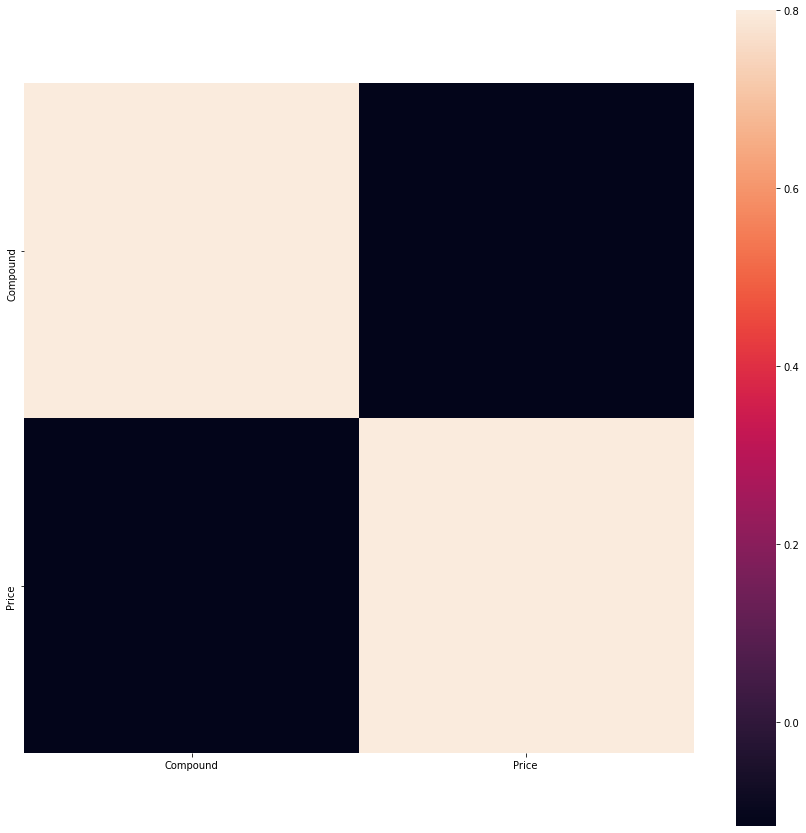

In [ ]:
import seaborn as sb
# How many of features are correlated


C_mat = df.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()
# Looks like 15 correlated features

In [ ]:
np.corrcoef(df['Compound'], df['Price '])

array([[ 1.        , -0.11610547],
       [-0.11610547,  1.        ]])

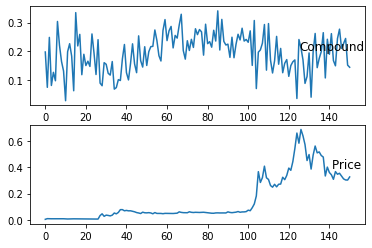

In [ ]:
values = df.values
# specify columns to plot
groups = [ 1,2]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [ ]:

df.set_index('Date',inplace=True)  
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df

,Price,Compound
Date,,
1/1/2021,0.005685,0.197971
1/2/2021,0.010615,0.075553
1/3/2021,0.009771,0.248539
1/4/2021,0.009767,0.082018
1/5/2021,0.009920,0.127530
...,...,...
5/27/2021,0.332945,0.210520
5/28/2021,0.311205,0.227102
5/29/2021,0.303110,0.244916


In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [ ]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
n_hours = 1  #no of time lags
n_features = 1 #no of features
n_obs = n_hours*n_features

In [ ]:

reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.000000,0.542059,0.007259,0.148736
2,0.007259,0.148736,0.006016,0.704531
3,0.006016,0.704531,0.006011,0.169509
4,0.006011,0.169509,0.006237,0.315736
5,0.006237,0.315736,0.007039,0.222019


In [ ]:
reframed = reframed.drop(reframed.columns[-1], axis=1)
reframed.head()

,var1(t-1),var2(t-1),var1(t)
1,0.000000,0.542059,0.007259
2,0.007259,0.148736,0.006016
3,0.006016,0.704531,0.006011
4,0.006011,0.169509,0.006237
5,0.006237,0.315736,0.007039


In [ ]:
reframed.shape

(150, 3)

In [ ]:

values = reframed.values
n_train_hours = 135
train = values[:135, :]
test = values[135:151, :]
train.shape,test.shape

((135, 3), (15, 3))

In [ ]:
values.shape

(150, 3)

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, ]
test_X, test_y = test[:, :n_obs], test[:, ]

In [ ]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((135, 1), (135, 3), (15, 1), (15, 3))

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(135, 1, 1) (135, 3) (15, 1, 1) (15, 3)


In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(135, 1, 1) (135,) (15, 1, 1) (15, 1)


In [ ]:
# design network
#model = Sequential()
#model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=15, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')



history = model.fit(train_X, train_y, epochs=60, batch_size=15, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/60
9/9 - 8s - loss: 0.0881 - val_loss: 0.2469
Epoch 2/60
9/9 - 0s - loss: 0.0815 - val_loss: 0.2267
Epoch 3/60
9/9 - 0s - loss: 0.0752 - val_loss: 0.2053
Epoch 4/60
9/9 - 0s - loss: 0.0686 - val_loss: 0.1829
Epoch 5/60
9/9 - 0s - loss: 0.0641 - val_loss: 0.1606
Epoch 6/60
9/9 - 0s - loss: 0.0606 - val_loss: 0.1399
Epoch 7/60
9/9 - 0s - loss: 0.0585 - val_loss: 0.1229
Epoch 8/60
9/9 - 0s - loss: 0.0571 - val_loss: 0.1097
Epoch 9/60
9/9 - 0s - loss: 0.0545 - val_loss: 0.0997
Epoch 10/60
9/9 - 0s - loss: 0.0544 - val_loss: 0.0914
Epoch 11/60
9/9 - 0s - loss: 0.0534 - val_loss: 0.0840
Epoch 12/60
9/9 - 0s - loss: 0.0512 - val_loss: 0.0774
Epoch 13/60
9/9 - 0s - loss: 0.0485 - val_loss: 0.0705
Epoch 14/60
9/9 - 0s - loss: 0.0459 - val_loss: 0.0624
Epoch 15/60
9/9 - 0s - loss: 0.0404 - val_loss: 0.0515
Epoch 16/60
9/9 - 0s - loss: 0.0358 - val_loss: 0.0393
Epoch 17/60
9/9 - 0s - loss: 0.0292 - val_loss: 0.0280
Epoch 18/60
9/9 - 0s - loss: 0.0247 - val_loss: 0.0181
Epoch 19/60
9/9 - 0

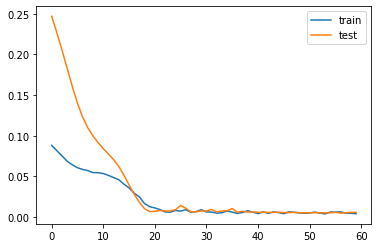

In [ ]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

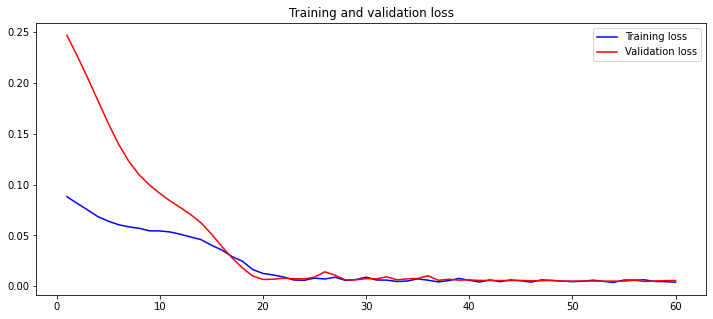

In [ ]:
#plt.style.use('ggplot')

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


plot_history(history)

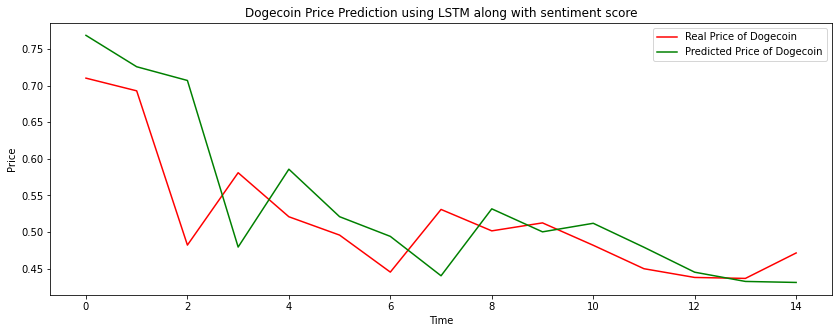

In [ ]:


yhat = model.predict(test_X)
yhat
plt.figure(figsize=(14,5))
plt.plot(test_y, color = 'red', label = 'Real Price of Dogecoin')
plt.plot(yhat, color = 'green', label = 'Predicted Price of Dogecoin')
plt.title('Dogecoin Price Prediction using LSTM along with sentiment score')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error 
realVals = test_y
predictedVals = yhat
mse = mean_squared_error(realVals, predictedVals)
mse

0.0056806325692770505

In [ ]:
# make a prediction
yhat = model.predict(test_X)
yhat

array([[0.76848817],
       [0.72563237],
       [0.7068849 ],
       [0.47948545],
       [0.5857553 ],
       [0.5209135 ],
       [0.4940428 ],
       [0.44026014],
       [0.5316535 ],
       [0.5002417 ],
       [0.51191473],
       [0.47920537],
       [0.44514894],
       [0.43253374],
       [0.4311551 ]], dtype=float32)

In [ ]:


test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.051


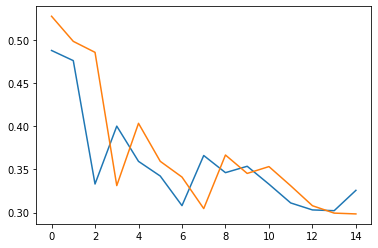

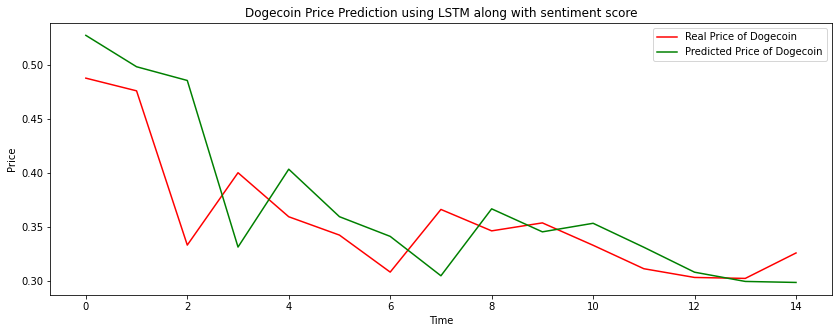

In [ ]:
plt.plot(inv_y)
plt.plot(inv_yhat)

plt.figure(figsize=(14,5))
plt.plot(inv_y, color = 'red', label = 'Real Price of Dogecoin')
plt.plot(inv_yhat, color = 'green', label = 'Predicted Price of Dogecoin')
plt.title('Dogecoin Price Prediction using LSTM along with sentiment score')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()